In [1]:
import numpy as np
from upkit import Histo, Histo2D
import scipy as sp
import pandas as pd
from signal_NN import SignalNN
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from utils import *
import matplotlib.pyplot as plt

# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('float32')


In [ ]:
# x_train, x_test, y_train, y_test = generate_synthetic_data(num_events=1_000_000, n_features=10, signal_fraction=0.25, random_state=42)

x_train, x_test, y_train, y_test = generate_correlated_toy(num_events=1_000_000, signal_fraction=0.1, rng=42)

print(f"Training set size: {x_train.shape}, Test set size: {x_test.shape}")

In [ ]:
model = SignalNN(input_shape=(x_train.shape[1], ), num_classes=1)

model.train(x_train, y_train, epochs=50, batch_size=512, validation_split=0.2, verbose=1)

loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

probs = model.predict(x_test)

In [ ]:
def plot_loss_history(history):
    """
    Plots the training and validation loss over epochs.
    """
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss over Epochs')
    ax.legend()
    plt.show()

def plot_probability_distribution(y_test, probs):
    """
    Plots the distribution of predicted probabilities for signal and background.
    """

    fig, ax = plt.subplots(figsize=(8,6))
    Histo(probs[y_test==0], bins=50, range=(0,1), label='Background', ax = ax, density=True)
    Histo(probs[y_test==1], bins=50, range=(0,1), label='Signal', ax = ax, density=True)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.legend()
    plt.show()

def plot_roc_curve(y_test, probs):
    """
    Plots the ROC curve and computes the AUC.
    """
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend()
    plt.show()

def plot_feature_space(x_test, y_test, probs, f1=1, f2=6):
    """
    Plots the feature space of two selected features, colored by true labels and model predictions.

    Parameters:
        - x_test: Test feature data.
        - y_test: True labels for the test data.
        - probs: Predicted probabilities from the model.
        - f1: Index of the first feature to plot.
        - f2: Index of the second feature to plot.

    Returns:
        - None
    """
    true_colors = y_test.astype(float)
    plt.figure(figsize=(12,5))

    # Left: true labels
    plt.subplot(1, 3, 1)
    sc1 = plt.hexbin(x_test[:, f1], x_test[:, f2],
                     cmap='coolwarm', alpha=0.6)
    plt.xlabel(f"x{f1}")
    plt.ylabel(f"x{f2}")
    plt.title("True Labels (as gradient)")
    # cbar1 = plt.colorbar(sc1, label="True Signal Probability")
    # cbar1.set_ticks([0, 1])
    # cbar1.set_ticklabels(["Background (0)", "Signal (1)"])
    plt.grid(True, linestyle='--', alpha=0.5)

    # Middle: model predictions (colored by P(signal))
    plt.subplot(1, 3, 2)
    plt.hexbin(x_test[:, f1], x_test[:, f2],
               cmap='coolwarm', alpha=0.6)
    plt.xlabel(f"x{f1}")
    plt.ylabel(f"x{f2}")
    plt.title("Model Predictions (P(signal))")
    plt.colorbar(label="Predicted P(signal)")
    plt.grid(True, linestyle='--', alpha=0.5)

    # Right: Residuals (|true - predicted|)
    plt.subplot(1, 3, 3)
    residuals = np.abs(true_colors - probs.flatten())
    sc3 = plt.hexbin(x_test[:, f1], x_test[:, f2],
                            C=residuals, cmap='coolwarm', alpha=0.6)
    plt.xlabel(f"x{f1}")
    plt.ylabel(f"x{f2}")
    plt.title("Residuals |True - Predicted|")
    cbar3 = plt.colorbar(sc3, label="Residuals")
    plt.grid(True, linestyle='--', alpha=0.5)
      
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(x_test, y_test, probs, feature_index=5)->None:
      """
      Plots the distribution of a selected feature for:
      - True signal vs background
      - Predicted signal-like vs background-like events

      Parameters:
            - x_test: Test feature data
            - y_test: True labels for test data
            - probs: Predicted probabilities for test data
            - feature_index: Index of the feature to plot

      Returns:
            - None (displays plots)
    """
      fig, axs = plt.subplots(1, 2, figsize=(12,5))

      # Left: feature distribution by true label
      # All events
      Histo(x_test[:, feature_index],
            bins=50, range=(0.75, 1.15),
            label='All Events', alpha=0.5, ax=axs[0])

      # Signal-like (predicted P(signal) > 0.5)
      Histo(x_test[y_test==1, feature_index],
            bins=50, range=(0.75, 1.15),
            label='Test Signal', histtype='step', alpha=0.8, ax=axs[0])

      # Background-like (predicted P(signal) <= 0.5)
      Histo(x_test[y_test==0, feature_index],
            bins=50, range=(0.75, 1.15),
            label='Test Background', histtype='step', alpha=0.8, ax=axs[0])

      axs[0].set_xlabel(f"x{feature_index}")
      axs[0].set_ylabel("Counts")
      axs[0].set_title("Feature Distribution by Real Labels")
      axs[0].legend()

      # Right: feature distribution by model classification
      # All events
      Histo(x_test[:, feature_index],
            bins=50, range=(0.75, 1.15),
            label='All Events', alpha=0.5, ax=axs[1])

      # Signal-like (predicted P(signal) > 0.5)
      Histo(x_test[probs.flatten()>0.5, feature_index],
            bins=50, range=(0.75, 1.15),
            label='Predicted Signal-like', histtype='step', alpha=0.8, ax=axs[1])   

      # Background-like (predicted P(signal) <= 0.5)
      Histo(x_test[probs.flatten()<=0.5, feature_index],
            bins=50, range=(0.75, 1.15),
            label='Predicted Background-like', histtype='step', alpha=0.8, ax=axs[1])

      axs[1].set_xlabel(f"x{feature_index}")
      # axs[1].set_ylabel("Normalized Counts")
      axs[1].set_title("Feature Distribution by Model Predictions")
      axs[1].legend()
      plt.show()

In [ ]:
plot_loss_history(model.model.history)
plot_roc_curve(y_test, probs)
plot_feature_distributions(x_test, y_test, probs, feature_index=0)
plot_probability_distribution(y_test, probs)
plot_feature_space(x_test, y_test, probs, f1=2, f2=4)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.8978 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4788 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5120 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3954 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4462 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4962 - learning_rate: 0.0010
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4872 - learning_rate: 0.0010
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6525 - learning_rate: 0.0010
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8681 - learning_rate: 5.0000e-04
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9803 - learning_rate: 5.0000e-04
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9501 - learning_rate: 5.0000e-04
Epoch 1

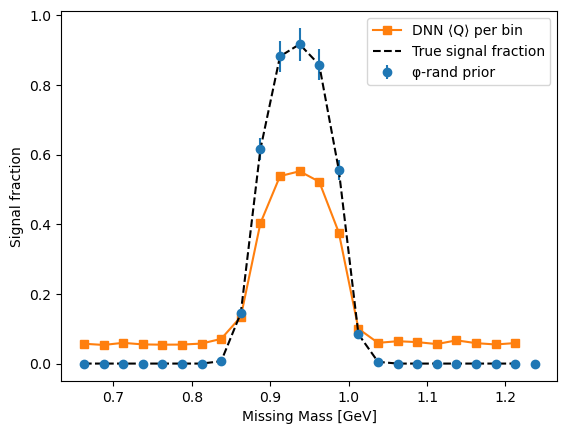

In [5]:
# Get toy data
X_train, X_test, y_train, y_test = generate_correlated_toy(num_events=200_000, signal_fraction=0.2)

# Columns: [MM, p_mag, Q2, W, costheta]
MM_train = X_train[:, 0]
X_features = X_train[:, 1:]        # exclude MM -> hypersphere features
import numpy as np
import pandas as pd

mm_bins = np.linspace(0.65, 1.25, 25)
bin_centers = 0.5*(mm_bins[1:] + mm_bins[:-1])
inds = np.digitize(MM_train, mm_bins, right=True) - 1
inds = np.clip(inds, 0, len(bin_centers) - 2)  # ensure indices stay valid

# Use only kinematic features (exclude MM)
# X_features = X_train[:, 1:].astype(np.float32)

pi_s_list = []
pi_s_unc_list = []
for j in range(len(bin_centers)):
    mask = inds == j
    if np.any(mask):
        yb = y_train[mask]
        s_frac = yb.mean()                   # true signal fraction
        pi_s_list.append(s_frac)
        # assume φ-rand ±5 % relative uncertainty for realism
        pi_s_unc_list.append(0.05 * s_frac + 1e-3)
    else:
        pi_s_list.append(0.0)
        pi_s_unc_list.append(0.0)

pi_s = np.array(pi_s_list, dtype=np.float32)
pi_s_unc = np.array(pi_s_unc_list, dtype=np.float32)

import tensorflow as tf

def make_llp_dataset(X, bin_indices, pi_s, pi_s_unc, batch_size=1024, bins_per_batch=10):
    bins = np.unique(bin_indices)
    while True:
        chosen_bins = np.random.choice(bins, bins_per_batch, replace=False)
        mask = np.isin(bin_indices, chosen_bins)
        Xb = X[mask]
        inds = bin_indices[mask]
        if len(Xb) < batch_size:
            continue

        idx = np.random.choice(len(Xb), batch_size, replace=False)
        X_batch = Xb[idx]
        bin_batch = inds[idx]

        y_batch = np.stack([
            pi_s[bin_batch],
            pi_s_unc[bin_batch],
            bin_batch
        ], axis=1).astype(np.float32)
        yield X_batch, y_batch


ds_llp = tf.data.Dataset.from_generator(
    lambda: make_llp_dataset(X_features, inds, pi_s, pi_s_unc),
    output_signature=(
        tf.TensorSpec(shape=(None, X_features.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)


model_llp = SignalNN(input_shape=(X_features.shape[1], ), pi_s = pi_s)
model_llp.train(
    ds_llp,
    steps_per_epoch=50,
    epochs=30
)

Q_pred = model_llp.predict(X_features)

means_pred, means_true = [], []
for j in range(len(bin_centers)):
    mask = inds == j
    if np.any(mask):
        means_pred.append(Q_pred[mask].mean())
        means_true.append(y_train[mask].mean())

import matplotlib.pyplot as plt
plt.errorbar(bin_centers, pi_s, yerr=pi_s_unc, fmt='o', label='φ-rand prior')
plt.plot(bin_centers[:-1], means_pred, 's-', label='DNN ⟨Q⟩ per bin')
plt.plot(bin_centers[:-1], means_true, 'k--', label='True signal fraction')
plt.xlabel('Missing Mass [GeV]')
plt.ylabel('Signal fraction')
plt.legend()
plt.show()

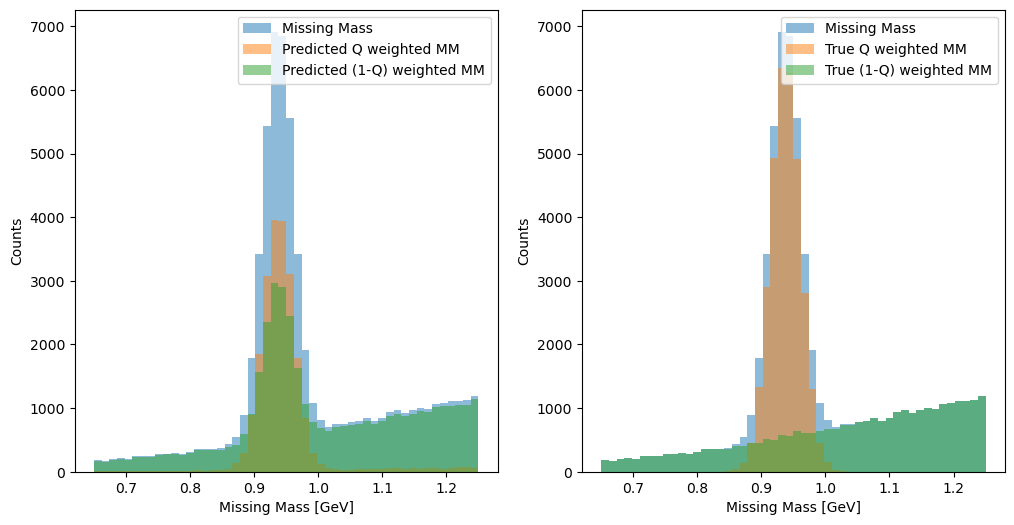

In [3]:

# plt.hist(Q_pred, bins=30, alpha=0.5, label='Predicted Q')
# plt.hist(y_train, bins=30, alpha=0.5, label='True Q')
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].hist(MM_train, bins=50, range=(0.65, 1.25), alpha=0.5, label='Missing Mass')
ax[0].hist(MM_train, bins=50, range=(0.65, 1.25), weights=Q_pred, alpha=0.5, label='Predicted Q weighted MM')
ax[0].hist(MM_train, bins=50, range=(0.65, 1.25), weights=1-Q_pred, alpha=0.5, label='Predicted (1-Q) weighted MM')

ax[1].hist(MM_train, bins=50, range=(0.65, 1.25), alpha=0.5, label='Missing Mass')
ax[1].hist(MM_train, bins=50, range=(0.65, 1.25), weights = y_train, alpha=0.5, label='True Q weighted MM')
ax[1].hist(MM_train, bins=50, range=(0.65, 1.25), weights = 1-y_train, alpha=0.5, label='True (1-Q) weighted MM')
for a in ax:
    a.set_xlabel('Missing Mass [GeV]')
    a.set_ylabel('Counts')
    a.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# import numpy as np

import tensorflow as tf

def make_llp_dataset(X, bin_indices, pi_s, pi_s_unc, batch_size=512):
    bins = np.unique(bin_indices)
    counts = np.bincount(bin_indices)
    probs = counts[bins] / counts[bins].sum()

    while True:
        chosen_bin = np.random.choice(bins, p=probs)
        mask = bin_indices == chosen_bin
        Xb = X[mask]
        if len(Xb) < batch_size:
            continue
        idx = np.random.choice(len(Xb), batch_size, replace=False)
        X_batch = Xb[idx]

        # y_batch = [π_s, σ_πₛ]
        y_batch = np.full((batch_size, 2),
                          [pi_s[chosen_bin], pi_s_unc[chosen_bin]],
                          dtype=np.float32)
        yield X_batch, y_batch


ds_llp = tf.data.Dataset.from_generator(
    lambda: make_llp_dataset(X_features, inds, pi_s, pi_s_unc),
    output_signature=(
        tf.TensorSpec(shape=(None, X_features.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)


@tf.function
@tf.function
def llp_loss(y_true, y_pred):
    pi_s   = y_true[:, 0]
    sigma  = y_true[:, 1]

    q_mean = tf.reduce_mean(y_pred)
    pi_mean = tf.reduce_mean(pi_s)
    sigma_mean = tf.reduce_mean(sigma)

    diff = (q_mean - pi_mean) / (sigma_mean + 1e-6)
    base_loss = tf.square(diff)

    # encourage prediction diversity
    p = tf.clip_by_value(y_pred, 1e-6, 1-1e-6)
    entropy = -tf.reduce_mean(p * tf.math.log(p) + (1-p) * tf.math.log(1-p))

    # combine
    return base_loss - 0.01 * entropy   # β≈0.01 is a good starting point


class SignalNN:
    def __init__(self, input_shape):
        self.model = self.build_model(input_shape)

    def build_model(self, input_shape):
        model = models.Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3)
        model.compile(optimizer=optimizer, loss=llp_loss)
        return model

    def train(self, dataset, epochs=20, steps_per_epoch=200):
        lr_reducer = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
        early_stopper = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        self.model.fit(dataset,
                       epochs=epochs,
                       steps_per_epoch=steps_per_epoch,
                       callbacks=[lr_reducer, early_stopper],
                       verbose=1)

    def predict(self, X):
        return self.model.predict(X)


nn = SignalNN((X_features.shape[1],))
nn.train(ds_llp, epochs=10, steps_per_epoch=300)


In [ ]:
Q_pred = nn.predict(X_features)

In [ ]:
means_pred, means_true = [], []
for j in range(len(bin_centers)):
    mask = inds == j
    if np.any(mask):
        means_pred.append(Q_pred[mask].mean())
        means_true.append(y_train[mask].mean())

import matplotlib.pyplot as plt
plt.errorbar(bin_centers, pi_s, yerr=pi_s_unc, fmt='o', label='φ-rand prior')
plt.plot(bin_centers[:-1], means_pred, 's-', label='DNN ⟨Q⟩ per bin')
plt.plot(bin_centers[:-1], means_true, 'k--', label='True signal fraction')
plt.xlabel('Missing Mass [GeV]')
plt.ylabel('Signal fraction')
plt.legend()
plt.show()

In [ ]:
# %%
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# ----------------------------------------------------------
# Use your provided correlated toy generator
# ----------------------------------------------------------
def sample_costheta_signal(n, a=0.5):
    u = np.random.uniform(0, 1, n)
    m = max(3*n, 20000)
    z = np.random.uniform(-1, 1, m)
    w = 1 + a*z**2
    w /= w.max()
    accept = np.random.uniform(0, 1, m) < w
    out = z[accept][:n]
    if len(out) < n:
        out = np.pad(out, (0, n-len(out)), mode='edge')
    return out

def sample_costheta_background(n):
    z = np.random.uniform(-1, 1, n)
    return 0.7*z - 0.1*np.sign(z) + 0.1*np.random.normal(size=n)

def generate_correlated_toy(num_events=100_000, signal_fraction=0.5, rng=42):
    rs = np.random.default_rng(rng)
    n_sig = int(num_events * signal_fraction)
    n_bkg = num_events - n_sig
    Q2_sig = rs.gamma(shape=2.0, scale=1.2, size=n_sig) + 0.5
    Q2_bkg = rs.gamma(shape=1.6, scale=1.5, size=n_bkg) + 0.3
    ct_sig = np.clip(sample_costheta_signal(n_sig, a=0.6), -1, 1)
    ct_bkg = np.clip(sample_costheta_background(n_bkg), -1, 1)
    W_sig = 2.10 + 0.12*np.sqrt(Q2_sig) + rs.normal(0, 0.04, n_sig)
    W_bkg = 2.00 + 0.18*np.sqrt(Q2_bkg) + rs.normal(0, 0.06, n_bkg)
    p_sig = 1.5*(W_sig - 2.0)*(1 - 0.25*ct_sig) + rs.normal(0, 0.05, n_sig)
    p_bkg = 1.6*(W_bkg - 2.0)*(1 - 0.10*ct_bkg) + rs.normal(0, 0.5, n_bkg)
    mu_sig = 0.938
    sigma_sig = 0.015 + 0.005*np.sqrt(Q2_sig)
    MM_sig = rs.normal(mu_sig, sigma_sig)
    base_bkg = rs.normal(1.5, 0.4, size=n_bkg)
    eps = 0.05
    MM_bkg = base_bkg + eps*(base_bkg - 1.0)
    X_sig = np.column_stack([MM_sig, p_sig, Q2_sig, W_sig, ct_sig])
    X_bkg = np.column_stack([MM_bkg, p_bkg, Q2_bkg, W_bkg, ct_bkg])
    X = np.vstack([X_sig, X_bkg])
    y = np.concatenate([np.ones(n_sig, dtype=int), np.zeros(n_bkg, dtype=int)])
    idx = rs.permutation(len(y))
    return train_test_split(X[idx], y[idx], test_size=0.2, random_state=rng)

# ----------------------------------------------------------
# Generate toy data
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = generate_correlated_toy(num_events=200_000)
MM_train = X_train[:,0]
features_train = X_train[:,1:]  # exclude MM from input
print("Feature shape:", features_train.shape)

# ----------------------------------------------------------
# Build φ-rand-like priors per MM bin (π_s)
# ----------------------------------------------------------
n_bins = 30
bins = np.linspace(MM_train.min(), MM_train.max(), n_bins+1)
inds = np.digitize(MM_train, bins) - 1
inds = np.clip(inds, 0, n_bins - 1)

bins_centers = 0.5*(bins[1:] + bins[:-1])

# true fraction per bin (unknown to real analysis, but known here)
true_frac = np.array([y_train[inds==i].mean() if np.any(inds==i) else 0 for i in range(n_bins)])
# φ-rand prior = smoothed version of true_frac + noise
from scipy.ndimage import gaussian_filter1d
pi_s = gaussian_filter1d(true_frac, sigma=2)
pi_s_unc = 0.05*np.ones_like(pi_s)

plt.plot(bins_centers, true_frac, 'o-', label='True signal fraction')
plt.plot(bins_centers, pi_s, 'r--', label='φ-rand prior (πₛ)')
plt.xlabel("MM"); plt.ylabel("Signal fraction"); plt.legend(); plt.show()

# ----------------------------------------------------------
# Build dataset for LLP training
# ----------------------------------------------------------
def make_llp_dataset(X, bin_indices, pi_s, pi_s_unc, batch_size=1024, bins_per_batch=6):
    bins = np.unique(bin_indices)
    while True:
        chosen = np.random.choice(bins, bins_per_batch, replace=False)
        mask = np.isin(bin_indices, chosen)
        Xb = X[mask]; gids = bin_indices[mask]
        if len(Xb) < batch_size: continue
        idx = np.random.choice(len(Xb), batch_size, replace=False)
        X_batch = Xb[idx]; gid_batch = gids[idx]
        y_batch = np.stack([
            pi_s[gid_batch],
            pi_s_unc[gid_batch],
            gid_batch
        ], axis=1).astype(np.float32)
        yield X_batch, y_batch

ds_llp = tf.data.Dataset.from_generator(
    lambda: make_llp_dataset(features_train, inds, pi_s, pi_s_unc),
    output_signature=(
        tf.TensorSpec(shape=(None, features_train.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

# ----------------------------------------------------------
# LLP loss (per-MM-bin mean constraint)
# ----------------------------------------------------------
@tf.function
def llp_loss(y_true, y_pred):
    pi_s   = y_true[:, 0]
    sigma  = y_true[:, 1]
    group  = tf.cast(y_true[:, 2], tf.int32)
    n_groups = tf.reduce_max(group) + 1
    q_mean = tf.math.unsorted_segment_mean(tf.squeeze(y_pred, -1), group, n_groups)
    pi_mean = tf.math.unsorted_segment_mean(pi_s, group, n_groups)
    sigma_mean = tf.math.unsorted_segment_mean(sigma, group, n_groups)
    sigma_eff = sigma_mean + 0.05
    per_group_loss = tf.square((q_mean - pi_mean) / (sigma_eff + 1e-6))
    return tf.reduce_mean(per_group_loss)

# ----------------------------------------------------------
# Model (no MM input!)
# ----------------------------------------------------------
mean_pi = np.mean(pi_s)
bias_init = np.log(mean_pi / (1 - mean_pi))
model = models.Sequential([
    layers.InputLayer(input_shape=(features_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid',
                 bias_initializer=tf.keras.initializers.Constant(bias_init))
])
model.compile(optimizer=tf.keras.optimizers.Adam(3e-3), loss=llp_loss)

# ----------------------------------------------------------
# Train
# ----------------------------------------------------------
history = model.fit(ds_llp, epochs=10, steps_per_epoch=200, verbose=1)

# ----------------------------------------------------------
# Evaluate (using *true* labels only for validation)
# ----------------------------------------------------------
Q_pred = model.predict(features_train).flatten()
for i in [5, 15, 25]:
    mask = inds == i
    if np.any(mask):
        print(f"Bin {i:02d}:  <Q>={Q_pred[mask].mean():.3f}, πₛ={pi_s[i]:.3f}, true={true_frac[i]:.3f}")

# Plot correlation between <Q> and πₛ
pred_means = [Q_pred[inds==i].mean() if np.any(inds==i) else np.nan for i in range(n_bins)]
plt.plot(bins_centers, pi_s, 'r--', label='πₛ prior')
plt.plot(bins_centers, pred_means, 'o-', label='Predicted ⟨Q⟩')
plt.plot(bins_centers, true_frac, 'k:', label='True fraction')
plt.xlabel("MM bin center"); plt.ylabel("Signal fraction")
plt.legend(); plt.grid(True); plt.show()
